This notebooks has for objective to identify optimal LFR_benchmark parameters to generate networks with similar graph properties as E Coli.

In [1]:
# Editing mode
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import random
from scipy.stats import pearsonr
import GRNgene as gg
import cma
import numpy as np
import pickle as pkl
from scipy.stats import ks_2samp
from scipy.optimize import curve_fit
random.seed(1)

# E.Coli network property

We load the E. Coli network from GeneNetWeaver (Schaffter et al., 2011).

In [40]:
filepath = '../../data/gnw/Ecoli-full.tsv'
adj_mx = gg.adj_mx_gnw_goldstandard(filepath)
ecoli_grn = nx.from_numpy_array(adj_mx, create_using=nx.DiGraph())

## Full network

We plot the log-log degree distribution to verify if it follows a power law distribution.

In [4]:
def power_law(x, a, b):
    return a * np.power(x, b)

def plot_degrees(
    G: nx.DiGraph,
    plot_fit: bool = False
):
    """
    Plot the total, in- and out- degree distribution of a network and optionally fit a power law.

    Parameters
    ----------
    G : nx.DiGraph
        Directed graph representing the gene regulatory network.
    
    plot_fit : bool, optional (default=False)
        If True, fit and overlay a power-law curve on the degree distribution plot.
        
    Returns
    -------
    None
        Displays the plots and prints the fitted power law parameters if `plot_fit` is True.
    """
    N = G.number_of_nodes()
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)
    degree_counts = np.unique(degree_sequence, return_counts=True)
    degrees = degree_counts[0]
    counts = degree_counts[1]
    probabilities = counts / N
               
    in_degree_sequence = sorted((d for n, d in G.in_degree()), reverse=True)
    in_dmax = max(in_degree_sequence)
    in_degree_counts = np.unique(in_degree_sequence, return_counts=True)
    in_degrees = in_degree_counts[0]
    in_counts = in_degree_counts[1]
    in_probabilities = in_counts / N

    out_degree_sequence = sorted((d for n, d in G.out_degree()), reverse=True)
    out_dmax = max(out_degree_sequence)
    out_degree_counts = np.unique(out_degree_sequence, return_counts=True)
    out_degrees = out_degree_counts[0]
    out_counts = out_degree_counts[1]
    out_probabilities = out_counts / N
    
    fig = plt.figure("Degree distribution", figsize=(8, 8))
    axgrid = fig.add_gridspec(3, 2)

    # Total degree
    ax0 = fig.add_subplot(axgrid[0, 0])
    ax0.scatter(np.log10(degrees), np.log10(probabilities), marker="o", color="b")
    ax0.set_title("log10-log10 Degree Distribution")
    ax0.set_ylabel("log10 P(k)")
    ax0.set_xlabel("log10 Degree k")
    
    # Fit and plot power law
    params = None
    if plot_fit:
        params, _ = curve_fit(power_law, degrees[degrees > 0], probabilities[degrees > 0])
        ax0.plot(
            np.log10(degrees[degrees > 0]),
            np.log10(power_law(degrees[degrees > 0], *params)),
            'r--',
            label='Power law fit'
        )
        ax0.legend()
    
    # Degree histogram
    ax1 = fig.add_subplot(axgrid[0, 1])
    ax1.bar(degrees, counts)
    ax1.set_title("Degree Histogram")
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("Number of Nodes")

    # In-degree
    ax2 = fig.add_subplot(axgrid[1, 0])
    ax2.scatter(np.log(in_degrees), np.log(in_probabilities), marker="o", color="b")
    ax2.set_title("Log-Log In-Degree Distribution")
    ax2.set_ylabel("Log P(k)")
    ax2.set_xlabel("Log Degree k")

    # Fit and plot power law
    params = None
    if plot_fit:
        params, _ = curve_fit(power_law, in_degrees[in_degrees > 0], in_probabilities[in_degrees > 0])
        ax1.plot(
            np.log(in_degrees[in_degrees > 0]),
            np.log(power_law(in_degrees[in_degrees > 0], *params)),
            'r--',
            label='Power law fit'
        )
        ax2.legend()

    # Degree histogram
    ax2 = fig.add_subplot(axgrid[1, 1])
    ax2.bar(in_degrees, in_counts)
    ax2.set_title("Degree Histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("Number of Nodes")
    
    # Out-degree
    ax3 = fig.add_subplot(axgrid[2, 0])
    ax3.scatter(np.log(out_degrees), np.log(out_probabilities), marker="o", color="b")
    ax3.set_title("Log-Log Out-Degree Distribution")
    ax3.set_ylabel("Log P(k)")
    ax3.set_xlabel("Log Degree k")

    # Fit and plot power law
    params = None
    if plot_fit:
        params, _ = curve_fit(power_law, out_degrees[out_degrees > 0], out_probabilities[out_degrees > 0])
        ax1.plot(
            np.log(out_degrees[out_degrees > 0]),
            np.log(power_law(out_degrees[out_degrees > 0], *params)),
            'r--',
            label='Power law fit'
        )
        ax3.legend()

    # Degree histogram
    ax4 = fig.add_subplot(axgrid[2, 1])
    ax4.bar(out_degrees, out_counts)
    ax4.set_title("Out-Degree Histogram")
    ax4.set_xlabel("Degree")
    ax4.set_ylabel("Number of Nodes")

    fig.tight_layout()
    plt.show()

    if params is not None:
        print(f"Fitted power law parameters: a = {params[0]:.2f}, b = {params[1]:.2f}")

/var/tmp/ipykernel_106419/803215833.py:77: RuntimeWarning: divide by zero encountered in log
  ax2.scatter(np.log(in_degrees), np.log(in_probabilities), marker="o", color="b")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/tmp/ipykernel_106419/803215833.py:103: RuntimeWarning: divide by zero encountered in log
  ax3.scatter(np.log(out_degrees), np.log(out_probabilities), marker="o", color="b")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


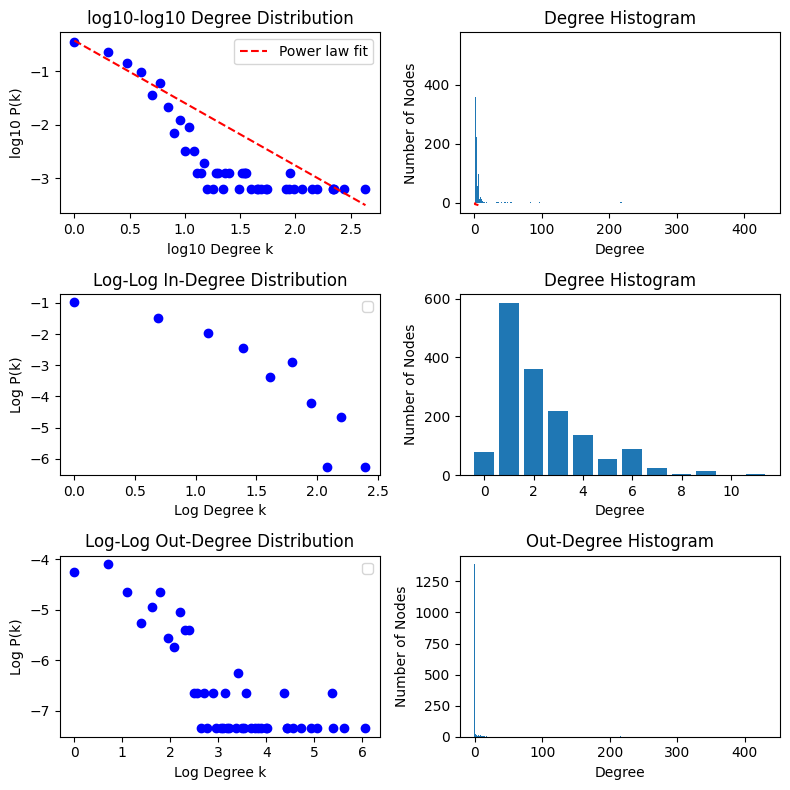

Fitted power law parameters: a = 0.02, b = -0.72


In [44]:
plot_degrees(ecoli_grn, plot_fit=True)

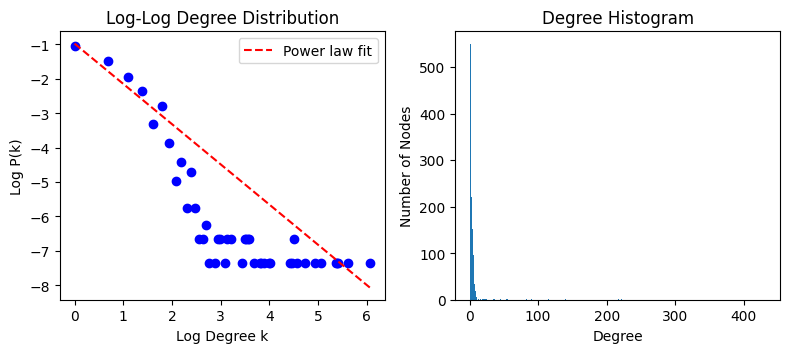

Fitted power law parameters: a = 0.38, b = -1.17


In [5]:
gg.plot_grn_degree(ecoli_grn, plot_network=False, plot_fit=True)
gnw_properties = gg.network_properties(ecoli_grn)

Multiple papers report biological network are scale free. 

This is usually illustrated by fitting a power law distribution, however as show here, the power law distribution does not fit well because of both the heavy tail and the curvature in the distrbution at log degree k aroud 2.

A better fit of the power law to either the log binning of cumulative distribution. (Barabsi Albert, Network Science)

In [6]:
#Get in- and out-degree distributions
deg_in_ecoli = np.array([d for _, d in ecoli_grn.in_degree()])
deg_out_ecoli = np.array([d for _, d in ecoli_grn.out_degree()])

In [7]:
deg_ecoli = np.array([d for _, d in ecoli_grn.degree()])

In [48]:
deg_ecoli.shape

(1564,)

In [49]:
gnw_properties

{'avg_clustering': 0.13291362343159122,
 'avg_degree': 4.664961636828645,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  18,  19,  20,  22,  23,  25,  31,  33,  34,  35,
         36,  40,  45,  46,  49,  54,  55,  83,  87,  90,  97, 115, 140,
        158, 217, 218, 222, 278, 431]),
 'density': 0.0014923101845261179,
 'degree_proba': array([0.35102302, 0.22826087, 0.14130435, 0.09654731, 0.03644501,
        0.06138107, 0.02109974, 0.00703325, 0.01214834, 0.00319693,
        0.00895141, 0.00319693, 0.00127877, 0.00127877, 0.00191816,
        0.00063939, 0.00063939, 0.00127877, 0.00127877, 0.00063939,
        0.00127877, 0.00127877, 0.00063939, 0.00127877, 0.00127877,
        0.00127877, 0.00127877, 0.00063939, 0.00063939, 0.00063939,
        0.00063939, 0.00063939, 0.00063939, 0.00063939, 0.00063939,
        0.00127877, 0.00063939, 0.00063939, 0.00063939, 0.00063939,
        0.00063939, 0.00063939, 0.00063939, 0.00063939, 0.000

We can identify that the full E.Coli network is not weakly connected.

Let us work with the largest component of E.Coli.

## Largest component

In [8]:
# Get the largest weakly connected component
largest_weakly_cc = max(nx.weakly_connected_components(ecoli_grn), key=len)

# Create the subgraph
ecoli_largest = ecoli_grn.subgraph(largest_weakly_cc).copy()

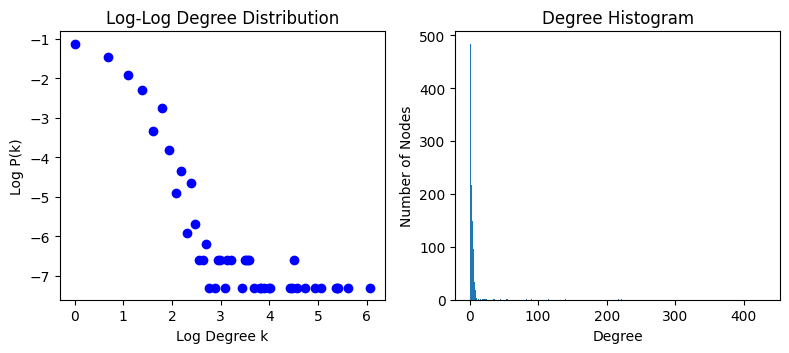

In [9]:
gg.plot_grn_degree(ecoli_largest, plot_network=False)
largest_gnw_properties = gg.network_properties(ecoli_largest)

In [52]:
largest_gnw_properties

{'avg_clustering': 0.1393885626587736,
 'avg_degree': 4.844955991875423,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  18,  19,  20,  22,  23,  25,  31,  33,  34,  35,
         36,  40,  45,  46,  49,  54,  55,  83,  87,  90,  97, 115, 140,
        158, 217, 218, 222, 278, 431]),
 'density': 0.0016412452547003467,
 'degree_proba': array([0.32701422, 0.23561273, 0.14691943, 0.10088016, 0.03588355,
        0.06431957, 0.02234259, 0.00744753, 0.01286391, 0.00270819,
        0.00947867, 0.00338524, 0.0013541 , 0.0013541 , 0.00203114,
        0.00067705, 0.00067705, 0.0013541 , 0.0013541 , 0.00067705,
        0.0013541 , 0.0013541 , 0.00067705, 0.0013541 , 0.0013541 ,
        0.0013541 , 0.0013541 , 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.0013541 , 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.0006

/var/tmp/ipykernel_106419/803215833.py:77: RuntimeWarning: divide by zero encountered in log
  ax2.scatter(np.log(in_degrees), np.log(in_probabilities), marker="o", color="b")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/tmp/ipykernel_106419/803215833.py:103: RuntimeWarning: divide by zero encountered in log
  ax3.scatter(np.log(out_degrees), np.log(out_probabilities), marker="o", color="b")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


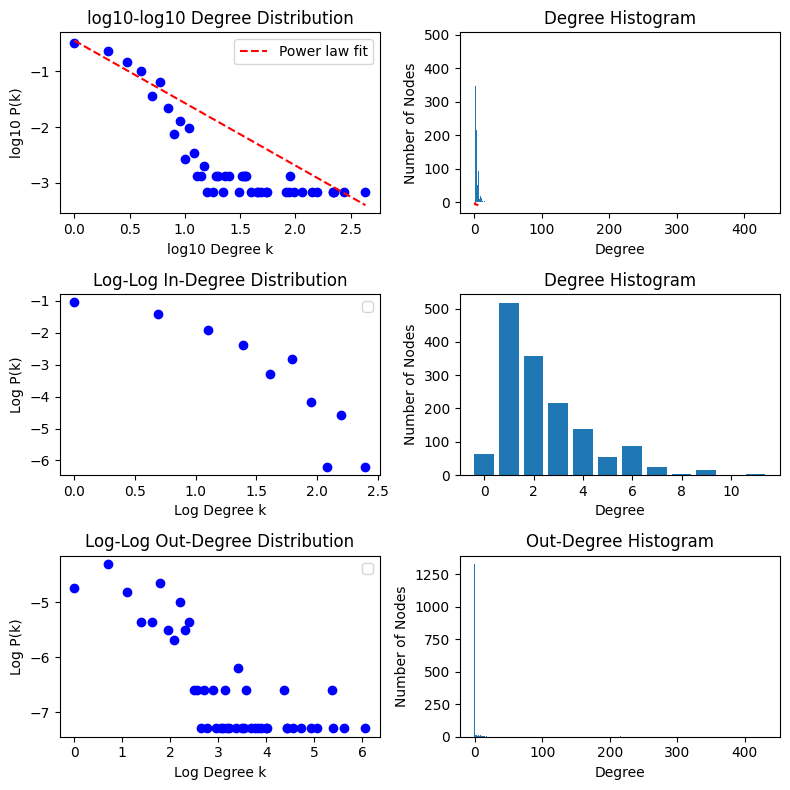

Fitted power law parameters: a = 0.01, b = -0.61


In [53]:
plot_degrees(ecoli_largest, plot_fit=True)

# Metric definition

In [54]:
def weighted_total_score(true_network, synthetic_network):
    degree_dist_true = np.array([d for _, d in true_network.degree()])
    degree_dist_synth = np.array([d for _, d in synthetic_network.degree()])
    ks_total = ks_2samp(degree_dist_true, degree_dist_synth)

    in_degree_dist_true = np.array([d for _, d in true_network.in_degree()])
    in_degree_dist_synth = np.array([d for _, d in synthetic_network.in_degree()])
    ks_in = ks_2samp(in_degree_dist_true, in_degree_dist_synth)

    out_degree_dist_true = np.array([d for _, d in true_network.out_degree()])
    out_degree_dist_synth = np.array([d for _, d in synthetic_network.out_degree()])
    ks_out = ks_2samp(out_degree_dist_true, out_degree_dist_synth)

    edge_true = true_network.number_of_edges()
    edge_synth = synthetic_network.number_of_edges()
    edge_diff = (edge_true - edge_synth)/edge_true

    avg_clustering_1 = nx.average_clustering(true_network)
    avg_clustering_2 = nx.average_clustering(synthetic_network)
    avg_clustering_diff = (avg_clustering_1 - avg_clustering_2)**2

    # Weights
    w_ks_total = 0.25
    w_ks_in = 0.2
    w_ks_out = 0.2
    w_edge = 0.25
    w_cluster = 0.1

    return (
        w_ks_total * ks_total +
        w_ks_in * ks_in +
        w_ks_out * ks_out +
        w_edge * edge_diff +
        w_cluster * avg_clustering_diff
    )

In [55]:
def evaluate_lfr(true_network, params):
    tau1, tau2, mu, hub_bias, min_community, max_community = params

    try:
        LFR_params = dict(
        n=true_network.number_of_nodes(),
        tau1=tau1,
        tau2=tau2,
        mu=mu,

        average_degree=4.8,
        min_community=min_community,
        max_community=max_community,
        hub_bias = hub_bias,
        seed=None
        )
        
        G_lfr = gg.LFRAlgorithm(max_retries=20,**LFR_params)

        G_lfr_directed = gg.adjacenteDiMatriceStaredFromGraph(
            G_lfr,
            autoRG=0.0,   # self-loop probability
            duoRG=0.005    # bidirectional edge probability
        )
        print(f"Computing score...")
        # Compare distributions
        score = total_score(true_network, G_lfr_directed[0])
        print(f"Score: {score}")
        return score

    except Exception:
        return np.inf  # penalize failures


# Optimization

In [58]:
import cma

# CMA-ES initial guess (tau1, tau2, mu, hub_bias, min_community, max_community)
x0 = [2.3, 1.2, 0.5, 3, 5, 500]
sigma0 = 0.3  # Initial standard deviation

es = cma.CMAEvolutionStrategy(x0, sigma0, {'bounds': [[1.5, 1.1, 0.05, 1, 2, 100], [5.0, 3.0, 0.85, 5, 50, 1000]]})

history = []

while not es.stop():
    solutions = es.ask()
    fitnesses = [evaluate_lfr(ecoli_largest, sol) for sol in solutions]
    for s, f in zip(solutions, fitnesses):
        history.append({'params': s, 'score': f})
    es.tell(solutions, fitnesses)
    es.logger.add()
    es.disp()
    # Save progress
    if es.countiter % 5 == 0:
        with open("cma_checkpoint.pkl", "wb") as f:
            pkl.dump(es, f)
        pd.DataFrame(history).to_csv("cma_history.csv", index=False)

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=606852, Wed May 28 15:50:01 2025)
Connected node 177 (deg=507) with 1170 (deg=2)
Graph is now connected (added 1 edges).
Computing score...
Computing score...
Computing score...
Computing score...
Generation failed on attempt 1, retrying...
Generation failed on attempt 2, retrying...
Generation failed on attempt 3, retrying...
Generation failed on attempt 4, retrying...
Generation failed on attempt 5, retrying...
Generation failed on attempt 6, retrying...
Generation failed on attempt 7, retrying...
Generation failed on attempt 8, retrying...
Generation failed on attempt 9, retrying...
Generation failed on attempt 10, retrying...
Generation failed on attempt 11, retrying...
Generation failed on attempt 12, retrying...
Generation failed on attempt 13, retrying...
Generation failed on attempt 14, retrying...
Generation failed on attempt 15, retrying...
Generation failed on attempt 16, retrying...
Generation failed on attempt 17, ret

/opt/conda/envs/venv_modelinf/lib/python3.10/site-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 1, 2, 3, 4, 5, 6, 7, 8] are not finite but [inf, inf, inf, inf, inf, inf, inf, inf, inf]. (time=May 28 15:51:03 2025 class=CMAEvolutionStrategy method=ask)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Computing score...
Generation failed on attempt 1, retrying...
Generation failed on attempt 2, retrying...
Generation failed on attempt 3, retrying...
Generation failed on attempt 4, retrying...
Generation failed on attempt 5, retrying...
Generation failed on attempt 6, retrying...
Generation failed on attempt 7, retrying...
Generation failed on attempt 8, retrying...
Generation failed on attempt 9, retrying...
Generation failed on attempt 10, retrying...
Generation failed on attempt 11, retrying...
Generation failed on attempt 12, retrying...
Generation failed on attempt 13, retrying...
Generation failed on attempt 14, retrying...
Generation failed on attempt 15, retrying...
Generation failed on attempt 16, retrying...
Generation failed on attempt 17, retrying...
Generation failed on attempt 18, retrying...
Generation failed on attempt 19, retrying...
Generation failed on attempt 20, retrying...
Computing score...
Connected node 532 (deg=539) with 37 (deg=2)
Connected node 1189 (deg=3

/opt/conda/envs/venv_modelinf/lib/python3.10/site-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 1, 2, 3, 4, 5, 6, 7, 8] are not finite but [inf, inf, inf, inf, inf, inf, inf, inf, inf]. (time=May 28 15:52:07 2025 class=CMAEvolutionStrategy method=ask iteration=1)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


# Load results

In [ ]:
import pickle

with open("cma_checkpoint.pkl", "rb") as f:
    es = pickle.load(f)

best_params = es.result.xbest
print("Best parameters:", best_params)

In [57]:
best_params = es.result.xbest
print("Best parameters:", best_params)

Best parameters: None


In [36]:
best_params = es.result.xbest
print("Best parameters:", best_params)

#Best parameters: [2.33349812 1.11019687 0.67158893 2.48584554 3.711577  ]

#Best parameters: [2.71053206e+00 1.63652171e+00 8.00312546e-02 3.22575933e+00
# 4.59093751e+00 5.00429652e+02]

Best parameters: [2.14144693e+00 1.49777239e+00 3.42400885e-01 3.31300918e+00
 4.64977436e+00 4.99829261e+02]


In [37]:
tau1, tau2, mu, hub_bias, min_community, max_community = [2.11905595, 1.20991633, 0.50243064, 3.14983374, 5.10054852, 500.4941408]

LFR_params = dict(
n=ecoli_largest.number_of_nodes(),
tau1=tau1,
tau2=tau2,
mu=mu,
seed=None,
average_degree=4.8,
min_community=min_community,
max_community=max_community,
hub_bias = hub_bias
)

G_lfr = gg.LFRAlgorithm(max_retries=20,**LFR_params)

G_lfr_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_lfr,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)

gg.network_properties(G_lfr_directed[0])

Generation failed on attempt 1, retrying...
Graph is disconnected. Connecting components...
Connected node 1113 (deg=343) with 95 (deg=2)
Connected node 1363 (deg=263) with 286 (deg=2)
Connected node 1363 (deg=264) with 853 (deg=1)
Connected node 1363 (deg=265) with 1389 (deg=1)
Graph is now connected (added 4 edges).
Successfully generated LFR graph on attempt 2.


{'avg_clustering': 0.037865836881202715,
 'avg_degree': 4.908598510494245,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         28,  29,  30,  33,  35,  37,  39,  40,  42,  45,  49,  59,  77,
         92, 201, 266, 346]),
 'density': 0.0016628043734736603,
 'degree_proba': array([0.11442112, 0.22004062, 0.23696682, 0.17874069, 0.09478673,
        0.04468517, 0.03452945, 0.0169262 , 0.00541638, 0.00473934,
        0.00338524, 0.00473934, 0.0013541 , 0.00270819, 0.00203114,
        0.00270819, 0.00270819, 0.00203114, 0.0013541 , 0.0013541 ,
        0.0013541 , 0.0013541 , 0.00338524, 0.00067705, 0.00067705,
        0.00067705, 0.0013541 , 0.00067705, 0.00067705, 0.0013541 ,
        0.0013541 , 0.00067705, 0.0013541 , 0.0013541 , 0.0013541 ,
        0.00067705, 0.00067705, 0.0013541 , 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705]),
 'modularity_value': 0.4

In [38]:
total_score(ecoli_largest,G_lfr_directed[0])

2209.8220875002744

In [24]:
tau1, tau2, mu, hub_bias, min_community, max_community = best_params

LFR_params = dict(
n=ecoli_largest.number_of_nodes(),
tau1=tau1,
tau2=tau2,
mu=mu,
seed=None,
average_degree=4.8,
min_community=min_community,
max_community=max_community,
hub_bias = hub_bias
)

G_lfr = gg.LFRAlgorithm(max_retries=20,**LFR_params)

G_lfr_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_lfr,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)

gg.network_properties(G_lfr_directed[0])

Generation failed on attempt 1, retrying...
Graph is disconnected. Connecting components...
Connected node 1360 (deg=66) with 13 (deg=6)
Connected node 400 (deg=62) with 404 (deg=3)
Connected node 44 (deg=28) with 558 (deg=1)
Connected node 1383 (deg=106) with 1350 (deg=1)
Graph is now connected (added 4 edges).
Successfully generated LFR graph on attempt 2.


{'avg_clustering': 0.05797148401791787,
 'avg_degree': 4.804333107650643,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  24,  25,  26,  27,  28,
         29,  31,  37,  41,  62,  63,  66, 107]),
 'density': 0.001627484115057806,
 'degree_proba': array([0.00947867, 0.1943128 , 0.23019634, 0.19566689, 0.13879485,
        0.08124577, 0.04603927, 0.02911307, 0.01286391, 0.01286391,
        0.01354096, 0.00541638, 0.00203114, 0.00406229, 0.00338524,
        0.00406229, 0.00203114, 0.00270819, 0.00067705, 0.0013541 ,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.0013541 ,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705]),
 'modularity_value': 0.8016104463547991,
 'nb_edges': 3548,
 'nb_nodes': 1477,
 'strongly_connected': False,
 'weakly_connected': True}

# Check solution

In [30]:
tau1, tau2, mu, hub_bias, average_degree = best_params

In [32]:
LFR_params = dict(
    n=ecoli_largest.number_of_nodes(),
    tau1=tau1,
    tau2=tau2,
    mu=mu,
    average_degree=average_degree,
    # min_community=10,
    # max_community=300,
    seed=None # Set seed for reproducibility
) # 2600 noeuds


hub_bias = hub_bias

# Generate LFR graph with retry loop to 1 since we set the seed
G_lfr = gg.LFRAlgorithm(max_retries=1,**LFR_params)

# Apply direction assignment
G_lfr_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_lfr,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)
#nx.write_adjlist(G_lfr_directed, "g_lfr_directed_final_2600.adjlist") # random

Graph is disconnected. Connecting components...
Connected node 1348 (deg=288) with 77 (deg=2)
Connected node 1348 (deg=289) with 1321 (deg=3)
Connected node 1081 (deg=237) with 993 (deg=2)
Connected node 153 (deg=64) with 231 (deg=2)
Connected node 469 (deg=127) with 271 (deg=2)
Connected node 1348 (deg=290) with 272 (deg=2)
Connected node 1348 (deg=291) with 830 (deg=2)
Connected node 48 (deg=64) with 1442 (deg=2)
Connected node 1081 (deg=238) with 1256 (deg=2)
Connected node 469 (deg=128) with 1360 (deg=2)
Connected node 1348 (deg=292) with 1469 (deg=1)
Graph is now connected (added 11 edges).
Successfully generated LFR graph on attempt 1.


In [25]:
synth_grn_properties = gg.network_properties(G_lfr_directed[0])

In [26]:
synth_grn_properties

{'avg_clustering': 0.05797148401791787,
 'avg_degree': 4.804333107650643,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  24,  25,  26,  27,  28,
         29,  31,  37,  41,  62,  63,  66, 107]),
 'density': 0.001627484115057806,
 'degree_proba': array([0.00947867, 0.1943128 , 0.23019634, 0.19566689, 0.13879485,
        0.08124577, 0.04603927, 0.02911307, 0.01286391, 0.01286391,
        0.01354096, 0.00541638, 0.00203114, 0.00406229, 0.00338524,
        0.00406229, 0.00203114, 0.00270819, 0.00067705, 0.0013541 ,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.0013541 ,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705]),
 'modularity_value': 0.8016104463547991,
 'nb_edges': 3548,
 'nb_nodes': 1477,
 'strongly_connected': False,
 'weakly_connected': True}

In [27]:
gnw_properties

{'avg_clustering': 0.1393885626587736,
 'avg_degree': 4.844955991875423,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  18,  19,  20,  22,  23,  25,  31,  33,  34,  35,
         36,  40,  45,  46,  49,  54,  55,  83,  87,  90,  97, 115, 140,
        158, 217, 218, 222, 278, 431]),
 'density': 0.0016412452547003467,
 'degree_proba': array([0.32701422, 0.23561273, 0.14691943, 0.10088016, 0.03588355,
        0.06431957, 0.02234259, 0.00744753, 0.01286391, 0.00270819,
        0.00947867, 0.00338524, 0.0013541 , 0.0013541 , 0.00203114,
        0.00067705, 0.00067705, 0.0013541 , 0.0013541 , 0.00067705,
        0.0013541 , 0.0013541 , 0.00067705, 0.0013541 , 0.0013541 ,
        0.0013541 , 0.0013541 , 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.0013541 , 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.0006

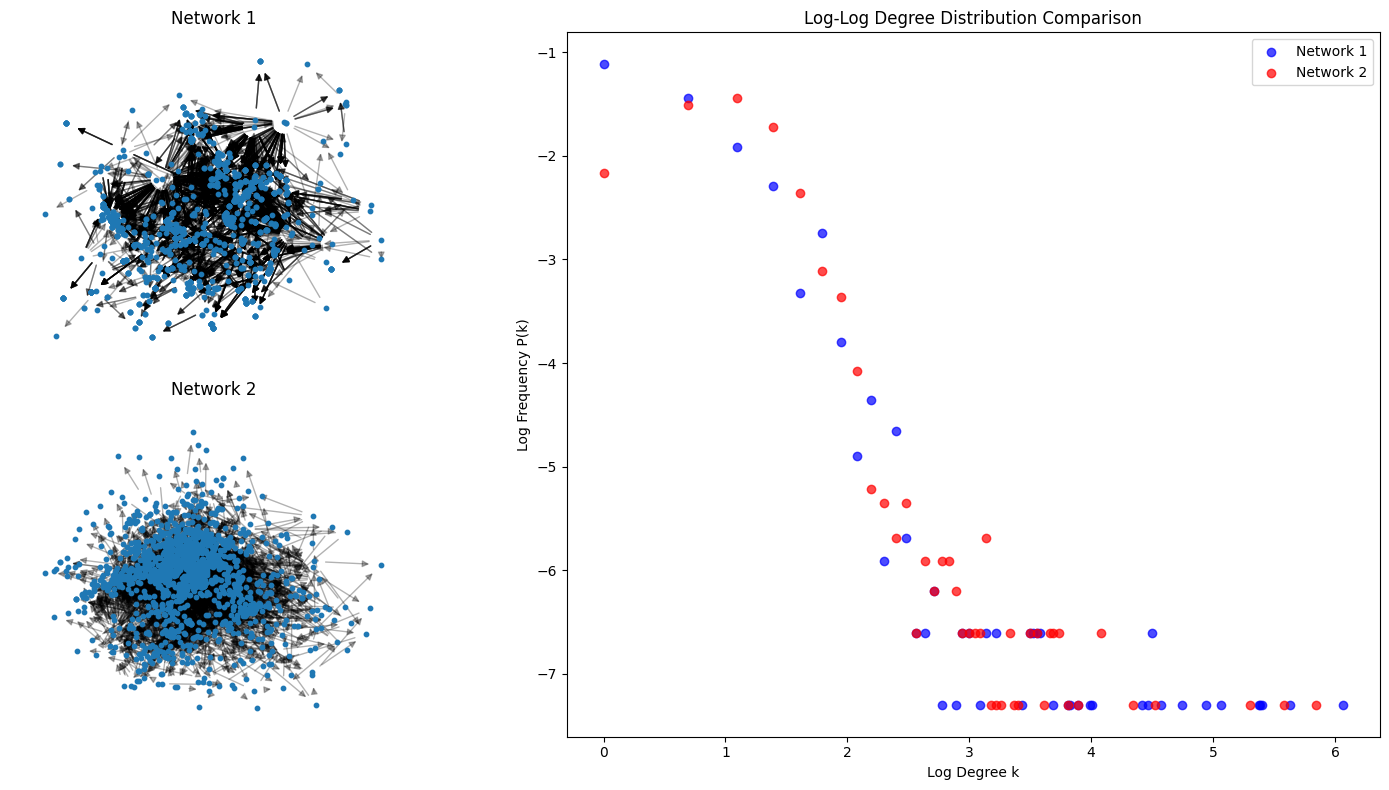

In [39]:
gg.plot_degree_network(ecoli_largest,G_lfr_directed[0])

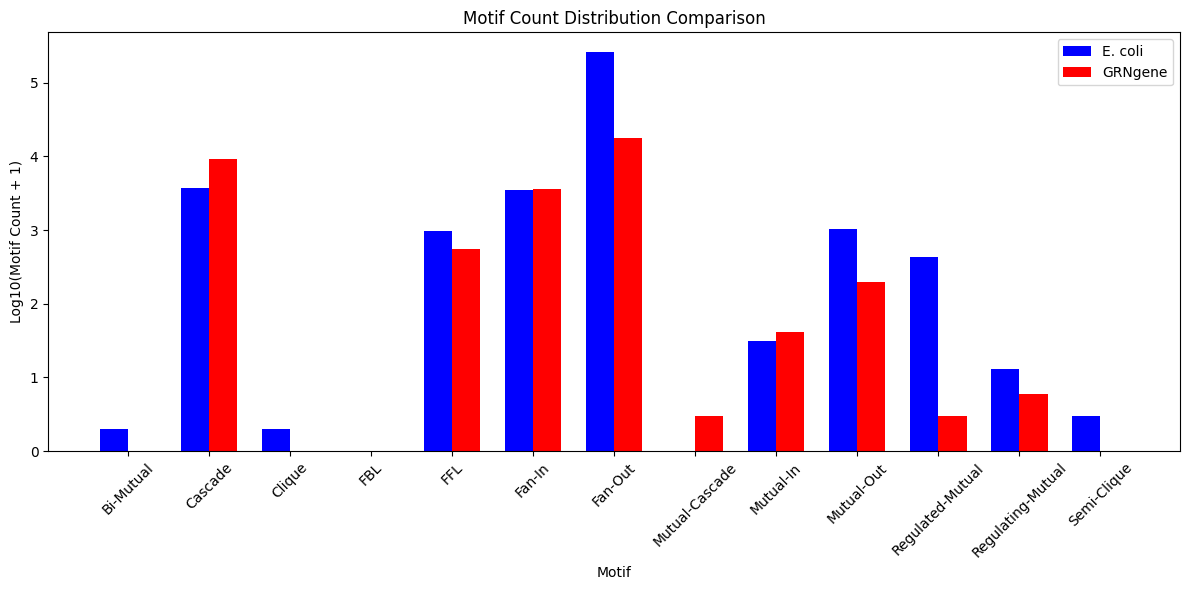

In [29]:
gg.compare_motif_dist(ecoli_largest, G_lfr_directed[0], "E. coli", "GRNgene")#, save_filename='motif_distribution.eps')

In [39]:
pearson_corr, pearson_p, spearman_corr, spearman_p = gg.correlation_metrics(ecoli_largest,  G_lfr_directed[0])

print(f"Pearson correlation: {pearson_corr:.3f} (p={pearson_p:.5f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p={spearman_p:.5f})")

Pearson correlation: 0.937 (p=0.00000)
Spearman correlation: 0.968 (p=0.00000)


# BA

In [20]:
# #x0 = [2.5, 1.5, 0.3, 3, 3.0]

# LFR_params = dict(
# n=2000,
# tau1=2.5,
# tau2=1.5,
# mu=0.3,
# seed=None,
# average_degree=4.5,
# # min_community=10,
# # max_community=300,
# hub_bias = 3.0
# ) # 2600 noeuds

# G_lfr = gg.LFRAlgorithm(max_retries=20,**LFR_params)

# G_lfr_directed = gg.adjacenteDiMatriceStaredFromGraph(
#     G_lfr,
#     autoRG=0.0,   # self-loop probability
#     duoRG=0.005    # bidirectional edge probability
# )

# deg_lfr = np.array([d for _, d in G_lfr_directed[0].degree()])  # or in_degree()

# # Compare distributions
# score = ks_2samp(deg_ecoli, deg_lfr).statistic
# print(score)

In [37]:
G_ba = gg.BarabasiAlbertAlgorithm(ecoli_largest.number_of_nodes(),4)

G_ba_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_ba,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)

deg_ba = np.array([d for _, d in G_ba_directed[0].degree()])  # or in_degree()

# Compare distributions
score_ba = ks_2samp(deg_ecoli, deg_ba).statistic
print(score_ba)

0.7165259468716396


In [38]:
synth_grn_properties = gg.network_properties(G_ba_directed[0])
synth_grn_properties

{'avg_clustering': 0.009661221078612059,
 'avg_degree': 7.976980365605958,
 'degrees': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 39,
        40, 43, 45, 46, 47, 49, 50, 53, 54, 55, 58, 61, 62, 67, 68, 81, 94]),
 'density': 0.00270222912114023,
 'degree_proba': array([0.00406229, 0.30670278, 0.17941774, 0.10900474, 0.09681787,
        0.05551794, 0.04536222, 0.0338524 , 0.03317536, 0.02640487,
        0.01218687, 0.01150982, 0.00947867, 0.00473934, 0.00744753,
        0.00609343, 0.00609343, 0.00541638, 0.00270819, 0.00338524,
        0.00338524, 0.00406229, 0.00338524, 0.0013541 , 0.00406229,
        0.0013541 , 0.00270819, 0.00067705, 0.00203114, 0.00203114,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.0013541 , 0.00067705, 0.00067705,
        0.0013541 , 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.0

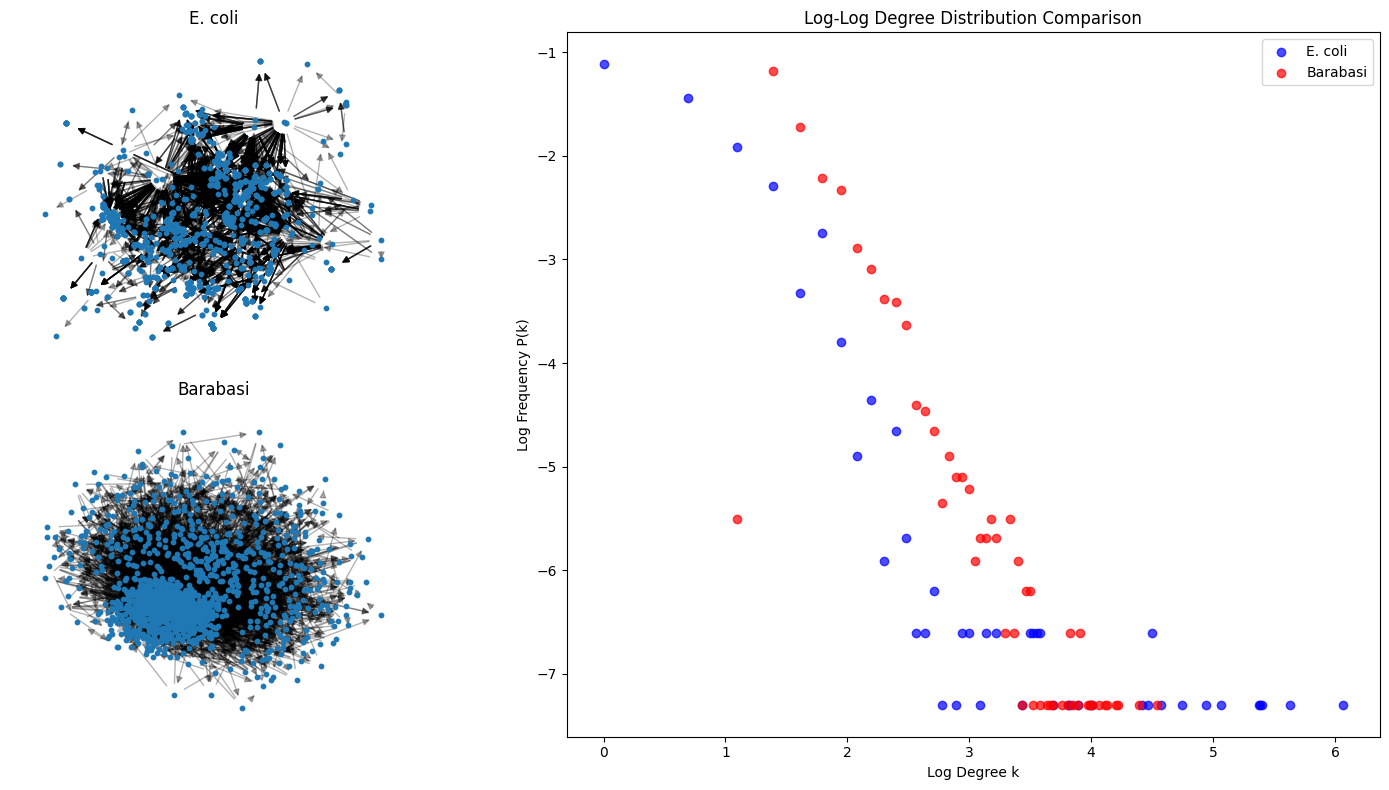

In [39]:
gg.plot_degree_network(ecoli_largest,G_ba_directed[0], 'E. coli', 'Barabasi')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/tmp/ipykernel_76090/803215833.py:103: RuntimeWarning: divide by zero encountered in log
  ax3.scatter(np.log(out_degrees), np.log(out_probabilities), marker="o", color="b")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


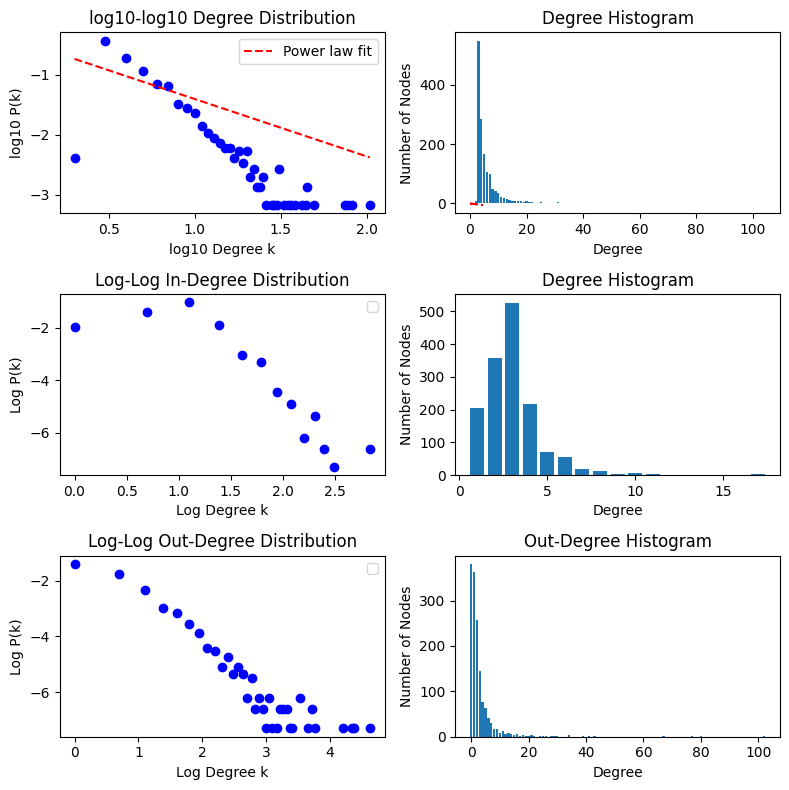

Fitted power law parameters: a = 0.27, b = -1.15


In [35]:
plot_degrees(G_ba_directed[0], plot_fit=True)

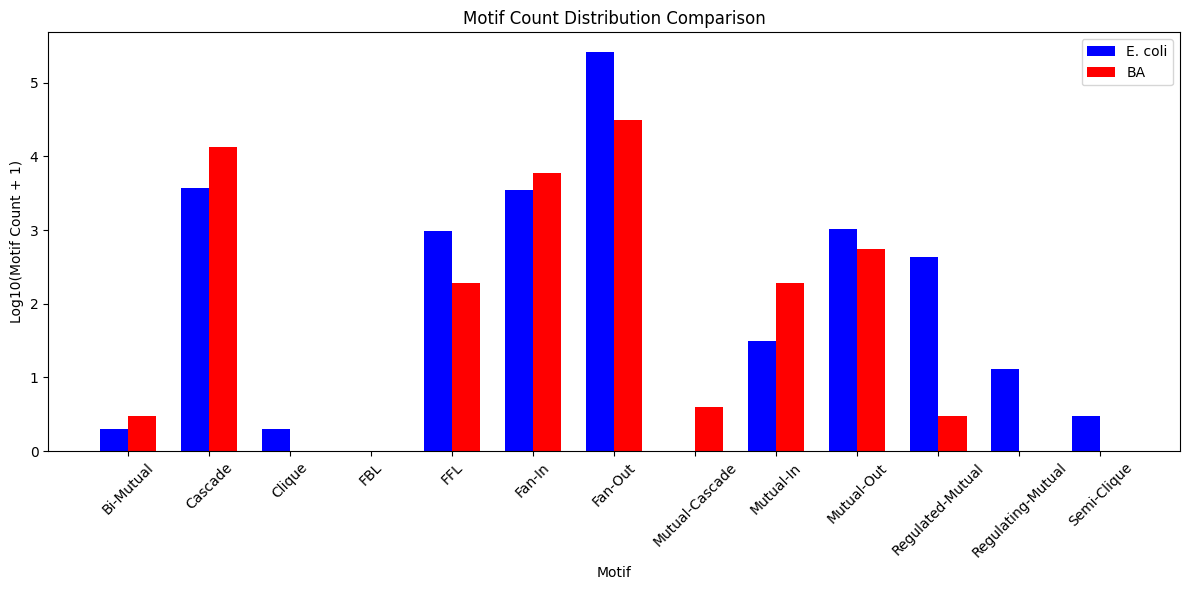

In [36]:
gg.compare_motif_dist(ecoli_largest, G_ba_directed[0], "E. coli", "BA")#, save_filename='motif_distribution.eps')

In [26]:
pearson_corr, pearson_p, spearman_corr, spearman_p = gg.correlation_metrics(ecoli_largest,  G_ba_directed[0])

print(f"Pearson correlation: {pearson_corr:.3f} (p={pearson_p:.5f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p={spearman_p:.5f})")

Pearson correlation: 0.680 (p=0.01060)
Spearman correlation: 0.959 (p=0.00000)


# References

Schaffter, T., Marbach, D., & Floreano, D. (2011). GeneNetWeaver: In silico benchmark generation and performance profiling of network inference methods. Bioinformatics, 27(16), 2263–2270. https://doi.org/10.1093/bioinformatics/btr373